In [1]:
def return_plot(estimator, plot=False):
    df['Predicted_Signal'] = estimator.predict(X)
    df.Predicted_Signal[df.Predicted_Signal > 0.5] = 1
    df.Predicted_Signal[df.Predicted_Signal < 0.5] = -1
    Cumulative_returns = np.cumsum(df[split:]['Returns'])
    df['Startegy_returns'] = df['Returns']* df['Predicted_Signal'].shift(1)
    Cumulative_Strategy_returns = np.cumsum(df[split:]['Startegy_returns'])
    print('Return: {}%'.format(round(Cumulative_Strategy_returns[-1]*100, 2)))
    
    if plot:
        plt.figure(figsize=(10,5))
        plt.plot(Cumulative_returns, color='r',label = 'Returns')
        plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
        plt.legend()
        plt.show()

def accuracy_plot(estimator):
    # summarize history for accuracy
    plt.plot(estimator.history.history['acc'])
    plt.plot(estimator.history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(estimator.history.history['loss'])
    plt.plot(estimator.history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def compare_plot(model_1, model_2):
    plt.plot(model_1.history.history['val_loss'], 'r', model_2.history.history['val_loss'], 'b')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Score')
    plt.legend(['first', 'second'])
    plt.show()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, Activation
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD, Adagrad, Adam
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

df = pd.read_csv('data1.csv', index_col='Datetime')
X = df.drop(['Target', 'Close'], axis=1).values
y = df.Target.values
split = int(len(df) * 0.60)
X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]
n_cols = X.shape[1]
y_train[y_train == -1] = 0

Using TensorFlow backend.


In [3]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Final Model

In [ ]:
early_stop = EarlyStopping(patience=300, monitor='auc_roc')
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
ada = Adagrad(lr=0.01, epsilon=None, decay=0.0)
adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [28]:
# 7 Layers
model = Sequential()
model.add(Dense(250, activation='relu', input_shape=(n_cols,)))
model.add(Dense(250, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(1, activation='sigmoid'))
adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=100, validation_split=0.3, callbacks=[early_stop], verbose=False)
return_plot(model)

Return: 56.6%


/anaconda2/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


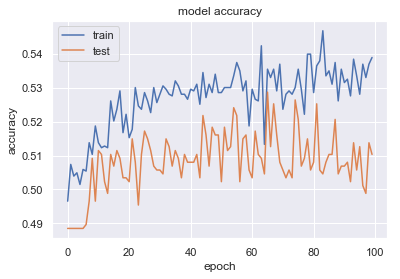

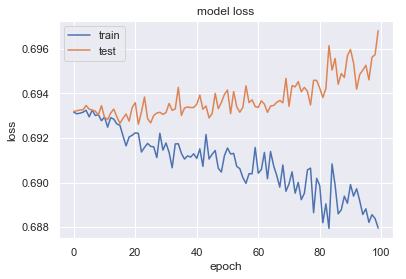

win rate: 41.37396694214876%


In [29]:
y_pred = model.predict(X_test)
y_pred = y_pred > 0.5
accuracy_plot(model)
print('win rate: {}%'.format(accuracy_score(y_test, y_pred)*100))

In [4]:
def make_model(dense_layers, activation, dropout):
    '''Creates a multi-layer perceptron model
    
    dense_layers: List of layer sizes; one number per layer
    '''

    model = Sequential()
    for i, layer_size in enumerate(dense_layers, 1):
        if i == 1:
            model.add(Dense(layer_size, input_dim=X.shape[1]))
            model.add(Activation(activation))
        else:
            model.add(Dense(layer_size))
            model.add(Activation(activation))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['binary_accuracy', auc_roc])

    return model

def auc_roc(y_true, y_pred):
    # any tensorflow metric
    value, update_op = tf.metrics.auc(y_true, y_pred)

    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value

In [5]:
param_grid = {'dense_layers': [[32], [32, 32], [64], [64, 64], [64, 64, 32], [64, 32], [128]],
              'activation'  : ['relu', 'tanh'],
              'dropout'     : [.25, .5, .75],
              }

clf = KerasClassifier(make_model, epochs=10, batch_size=128)
grid_cv = GridSearchCV(clf, param_grid, cv=5, refit=True, return_train_score=True, n_jobs=-1, verbose=1, iid=False, error_score=np.nan, scoring='roc_auc')
early_stop = EarlyStopping(monitor='auc_roc', patience=300, verbose=1, mode='max')

grid_cv.fit(X_train, y_train, callbacks=[early_stop], verbose=2, epochs=50)
print('\nBest Score: {:.2%}'.format(grid_cv.best_score_))
print('\nBest Params:\n', pd.Series(grid_cv.best_params_))

Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   37.6s
/anaconda2/envs/python3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda2/envs/python3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda2/envs/python3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a 

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:  3.3min finished


Instructions for updating:
Use tf.cast instead.
Epoch 1/50
 - 0s - loss: 0.7147 - binary_accuracy: 0.4990 - auc_roc: 0.4787
Epoch 2/50
 - 0s - loss: 0.6972 - binary_accuracy: 0.5031 - auc_roc: 0.5049
Epoch 3/50
 - 0s - loss: 0.6945 - binary_accuracy: 0.5258 - auc_roc: 0.5072
Epoch 4/50
 - 0s - loss: 0.6929 - binary_accuracy: 0.5217 - auc_roc: 0.5131
Epoch 5/50
 - 0s - loss: 0.6906 - binary_accuracy: 0.5186 - auc_roc: 0.5169
Epoch 6/50
 - 0s - loss: 0.6908 - binary_accuracy: 0.5282 - auc_roc: 0.5204
Epoch 7/50
 - 0s - loss: 0.6891 - binary_accuracy: 0.5334 - auc_roc: 0.5245
Epoch 8/50
 - 0s - loss: 0.6893 - binary_accuracy: 0.5403 - auc_roc: 0.5278
Epoch 9/50
 - 0s - loss: 0.6886 - binary_accuracy: 0.5372 - auc_roc: 0.5301
Epoch 10/50
 - 0s - loss: 0.6872 - binary_accuracy: 0.5337 - auc_roc: 0.5331
Epoch 11/50
 - 0s - loss: 0.6863 - binary_accuracy: 0.5475 - auc_roc: 0.5359
Epoch 12/50
 - 0s - loss: 0.6864 - binary_accuracy: 0.5534 - auc_roc: 0.5390
Epoch 13/50
 - 0s - loss: 0.6865 - bi

In [6]:
final_model = grid_cv.best_estimator_

In [7]:
return_plot(final_model)

Return: -10.84%


/anaconda2/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [8]:
y_pred = final_model.predict(X_test)
print(accuracy_score(y_test, y_pred)*100)

38.84297520661157
